## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:
* I would be interested to investigate features such as urine `albumin`, `random blood glucose`, `serum creatinine`, `hemoglobin`, `hypertension`, `Diabetes mellitus`, `coronary artery disease`, `pedal edema` in relation to `class`
* check for unbalanced features
* check for missing values

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [3]:
df.shape

(400, 25)

In [4]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [6]:
(df.isnull().sum()*100)/len(df) # try sortig the values from descending order

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [6]:
df_drop = df.dropna()
df_drop.shape

(158, 25)

Answer:
* Will lose a lot of good collateral data that might have been useful to feed the model
* Might make the model more biased, as the remaining complete data might be a biased representation of the target population

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:
* Some of the records that are not test results, e.g. questionaire answers ('yes' or 'no') might be inaccurate if the answers are from patient history, and patients are not known to be reliable with recollection of own health history.
* Also, doctors and nurses are usually in a rush, very busy people, sometimes questions are not carefully looked at, and answers are written down based on assumptions of what is already known. E.g. blood test results inference to a presence of chronic disease
* there is also inter-practitioner interpretation of what is `pedal edema`, or the grade of albumin and sugar in urine (nominal data points). so if data was collected by different people, might result in inconsistent scale of measurement

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: a baseline model, with a baseline value of `CKD` for all independent variables. 

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: we optimised **sensitivity/recall**. we minimised false negatives. 

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:
* This might result in wasted resources in further investigations, work-up, or even treatment, intervention, medications for patients that do not truly have CKD but were flagged positive by the model
* This will also cause undue distress and psychological trauma to patients that were flagged positive but do not truly have CKD, because they have to undergo unnecessary procedures and possibly intervention, treatment. Just the diagnosis alone is traumatic enough. the inconvenience endured for undergoing unnecessary intervention. harm might also be caused to patient, since risk will outweigh the benefit of the interventions for this situation. 

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: baseline model, with baseline set at value of `not CKD` for all independent variables.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We have now optimised for specificity. We minimised false positives.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: 
* Ethically, the model will deprive people who truly have CKD from receiving the care timely that they might urgently need if they had been flagged positive by the model. 
* The model might also reinforce self denial in people who have been diagnosed with CKD, but will seek anything to support their false beliefs that they don't.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [8]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


The minimum and maximum values for most numerical features seem reasonable, except for potassium, where the maximum value is 47, which is not compatible with life. Since I am not planning to use this feature for predicting presence of CKD, I will drop this feature. 

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression

In [10]:
print(df.columns.tolist())

['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']


In [11]:
X = df[['age','bp','al','sc','hemo','htn','dm','cad','appet','pe','ane']]
y = df['class']

In [12]:
X.shape

(400, 11)

In [13]:
X.isnull().sum()

age       9
bp       12
al       46
sc       17
hemo     52
htn       2
dm        2
cad       2
appet     1
pe        1
ane       1
dtype: int64

In [14]:
X.loc[X['ane'].isnull(), :]

,age,bp,al,sc,hemo,htn,dm,cad,appet,pe,ane
294,75.0,60.0,0.0,0.7,14.3,no,no,no,NaN,NaN,NaN


In [15]:
X.loc[X['cad'].isnull(), :]

,age,bp,al,sc,hemo,htn,dm,cad,appet,pe,ane
288,56.0,70.0,0.0,1.2,15.9,NaN,NaN,NaN,good,no,no
297,53.0,60.0,0.0,1.0,15.8,NaN,NaN,NaN,good,no,no


Since the features with low numbers of null values seem to share null values across multiple features, the rows can be dropped without impacting to many datapoints.

In [16]:
X.dropna(subset=['htn','dm','cad','appet','pe','ane'], inplace=True)
y.drop(index=[288,294,297], inplace=True)
X.shape

C:\Users\Maybelle\AppData\Local\Temp\ipykernel_21736\295537132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(subset=['htn','dm','cad','appet','pe','ane'], inplace=True)


(397, 11)

In [17]:
X.isnull().sum()

age       9
bp       12
al       46
sc       17
hemo     52
htn       0
dm        0
cad       0
appet     0
pe        0
ane       0
dtype: int64

In [18]:
# to make all values numerical by dummifying nominal values
X_dum = pd.get_dummies(data=X, drop_first=True)
X_dum.head(3)

,age,bp,al,sc,hemo,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.0,1.2,15.4,1,1,0,0,0,0
1,7.0,50.0,4.0,0.8,11.3,0,0,0,0,0,0
2,62.0,80.0,2.0,1.8,9.6,0,1,0,1,0,1


In [19]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X_dum, 
                                                    y, 
                                                    stratify=y, 
                                                    test_size=.2, 
                                                    random_state=42)

In [20]:
y_train.value_counts()

ckd       200
notckd    117
Name: class, dtype: int64

In [21]:
y_test.value_counts()

ckd       50
notckd    30
Name: class, dtype: int64

In [22]:
# impute missing values using KNNImputer
imp = KNNImputer()

imp_X_train = imp.fit_transform(X_train)
imp_X_test = imp.transform(X_test)

imp_X_train = pd.DataFrame(imp_X_train, columns=X_train.columns)
imp_X_test = pd.DataFrame(imp_X_test, columns=X_test.columns)

In [23]:
imp_X_train.isnull().sum()

age           0
bp            0
al            0
sc            0
hemo          0
htn_yes       0
dm_yes        0
cad_yes       0
appet_poor    0
pe_yes        0
ane_yes       0
dtype: int64

In [24]:
# standard scale data
ss = StandardScaler()
Z_train = ss.fit_transform(imp_X_train)
Z_test = ss.transform(imp_X_test)

In [25]:
# instantiate KNN classifier
knn = KNeighborsClassifier()

In [26]:
# cross validation to check what accuracy to expect
cross_val_score(knn, Z_train, y_train, cv=10).mean() 

0.9398185483870968

In [27]:
# fit model on both Z_train and Z_test
knn.fit(Z_train, y_train)
knn.score(Z_train, y_train)

0.9558359621451105

In [28]:
knn.score(Z_test, y_test)

0.9875

KNN model not overfitted. performing better on test set, than on training set

In [29]:
# try logistic regression model
logreg = LogisticRegression()

# Step 3: Fit our model on training data
logreg.fit(Z_train, y_train)

LogisticRegression()

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [30]:
print(f'Logistic Regression train accuracy score: {logreg.score(Z_train, y_train)}')
print(f'Logistic Regression test accuracy score: {logreg.score(Z_test, y_test)}')

Logistic Regression train accuracy score: 0.9747634069400631
Logistic Regression test accuracy score: 0.9875


In [31]:
logreg.predict(Z_test)[:6]

array(['ckd', 'ckd', 'ckd', 'ckd', 'ckd', 'notckd'], dtype=object)

In [32]:
logreg.predict_proba(Z_test)[:6]

array([[9.98626529e-01, 1.37347106e-03],
       [1.00000000e+00, 4.50165203e-11],
       [9.99997471e-01, 2.52914422e-06],
       [9.99999936e-01, 6.38784253e-08],
       [9.99999482e-01, 5.17628891e-07],
       [1.45501508e-01, 8.54498492e-01]])

In [33]:
print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-5.47193378]
Logistic Regression Coefficient: [[-0.0270173  -0.59692164 -2.00849949 -1.4279712   2.71024306 -1.15129703
  -1.61289243 -0.36356761 -0.99604782 -1.38935086 -0.54352748]]


In [34]:
pd.DataFrame(data={'feature':X_train.columns.tolist(), 'coef':logreg.coef_[0], 'exp':np.exp(logreg.coef_[0]) })

,feature,coef,exp
0,age,-0.027017,0.973344
1,bp,-0.596922,0.550504
2,al,-2.008499,0.134190
3,sc,-1.427971,0.239795
4,hemo,2.710243,15.032929
5,htn_yes,-1.151297,0.316226
6,dm_yes,-1.612892,0.199310
7,cad_yes,-0.363568,0.695192
8,appet_poor,-0.996048,0.369336
9,pe_yes,-1.389351,0.249237


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

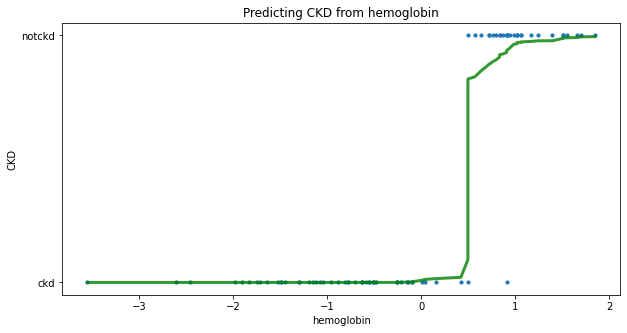

In [36]:
# Visualizing logistic regression probabilities.

plt.figure(figsize = (10, 5))

plt.scatter(Z_test[:,4], y_test, s=10);

plt.plot(sorted(Z_test[:,4]),
         # select column in dataframe type
         sorted(logreg.predict_proba(Z_test)[:,1]), 
         # choose the 2nd column values in 2D numpy array
         color = 'green', alpha = 0.8, lw = 3)

plt.xlabel('hemoglobin')
plt.ylabel('CKD')
plt.title('Predicting CKD from hemoglobin');

* The model is $\log\bigg(\frac{P(CKD=1)}{1-P(CKD=1)}\bigg) = \beta_0 + \beta_1\text{hemoglobin} + \cdots + \beta_px_p $
* As hemoglobin decreases by 1, the log-odds of someone having CKD increases by 2.71.
* As hemoglobin decreases by 1, someone is $e^{2.71}$ times as likely to have CKD.
* As hemoglobin decreases by 1, someone is about 15 times as likely to have CKD.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [37]:
pd.DataFrame(data={'feature':X_train.columns.tolist(), 'coef':logreg.coef_[0], 'exp':np.exp(logreg.coef_[0]) })

,feature,coef,exp
0,age,-0.027017,0.973344
1,bp,-0.596922,0.550504
2,al,-2.008499,0.134190
3,sc,-1.427971,0.239795
4,hemo,2.710243,15.032929
5,htn_yes,-1.151297,0.316226
6,dm_yes,-1.612892,0.199310
7,cad_yes,-0.363568,0.695192
8,appet_poor,-0.996048,0.369336
9,pe_yes,-1.389351,0.249237


* The model is $\log\bigg(\frac{P(CKD=1)}{1-P(CKD=1)}\bigg) = \beta_0 + \beta_1\text{cad} + \cdots + \beta_px_p $
* When yes to coronary artery disease, the log-odds of someone having CKD increases by 0.36.
* When yes to coronary artery disease, someone is $e^{0.36}$ times as likely to have CKD.
* When yes to coronary artery disease, someone is about 0.69 times as likely to not have CKD. Means almost twice likely to have CKD.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:
* Fast
* Explainable model

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

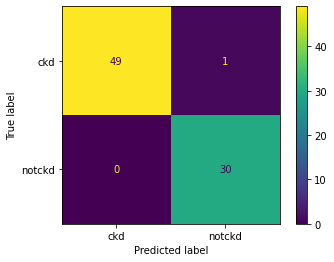

In [38]:
confusion_mat = confusion_matrix(y_test, logreg.predict(Z_test), labels=['ckd','notckd'])
ConfusionMatrixDisplay(confusion_mat, display_labels=['ckd','notckd']).plot();

To get a good understanding of how our model will do on new data, it is a more accurate measurement of model performance to generate confusion matrix using predictions made on test data. 

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: 
* I would want to optimise on accuracy, because consequences of high false positive rate and/or high false negative rates can be disastrous for both the healthcare systems and healthcare consumers. 

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:
* Unbalanced classes are a problem because the algorithm will be unable to learn enough from data to correctly predict minority classes. 
* In this particular CKD analysis, unbalanced class is a problem, because having CKD is the majority, and not having CKD is the minority class for this particular dataset. So I had to be careful when splitting my training and test set, to make sure that minority class is equally represented in both training and test sets. 

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:
* Unbalanced classes is a problem because it means the algorithm will not have enough data about rare diseases to make accurate predictions related to rare diseases, or uncommon illnesses.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

[Reference](https://datagy.io/pandas-sample/)

In [39]:
# make new column to assign weights, otherwise pd.sample weights parameter cannot interpret
df['weights'] = df['class'].map({'ckd':1, 'notckd':0}) 
df_bootstrap = df.sample(n=200000, replace=True, weights='weights', random_state=1)
df_final = pd.concat([df,df_bootstrap])
df_final.reset_index(drop=True, inplace=True)
df_final.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,weights
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,7800.0,5.2,yes,yes,no,good,no,no,ckd,1
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,6000.0,NaN,no,no,no,good,no,no,ckd,1
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,7500.0,NaN,no,yes,no,poor,no,yes,ckd,1


In [40]:
df_final.shape

(200400, 26)

In [41]:
df_final['class'].value_counts()

ckd       200250
notckd       150
Name: class, dtype: int64

In [42]:
df_final.tail(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,weights
200397,63.0,90.0,1.015,0.0,0.0,NaN,normal,notpresent,notpresent,123.0,...,11400.0,4.7,no,no,no,good,no,no,ckd,1
200398,60.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,269.0,...,NaN,NaN,yes,yes,yes,good,yes,no,ckd,1
200399,48.0,100.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,103.0,...,7200.0,2.6,yes,no,yes,poor,no,no,ckd,1


In [43]:
(150/200400) # proportion of notckd samples

0.0007485029940119761

New data from bootstrap also contains a lot of null values that have to be dealt with the same way as was done on original data. 

In [44]:
X_bst = df_final[['age','bp','al','sc','hemo','htn','dm','cad','appet','pe','ane']]
y_bst = df_final['class']

In [45]:
X_bst.isnull().sum()

age       6530
bp        8065
al       32931
sc        9710
hemo     36822
htn          2
dm           2
cad          2
appet        1
pe           1
ane          1
dtype: int64

In [46]:
X_bst.loc[X_bst['htn'].isnull(), :]

,age,bp,al,sc,hemo,htn,dm,cad,appet,pe,ane
288,56.0,70.0,0.0,1.2,15.9,NaN,NaN,NaN,good,no,no
297,53.0,60.0,0.0,1.0,15.8,NaN,NaN,NaN,good,no,no


In [47]:
X_bst.loc[X_bst['appet'].isnull(), :]

,age,bp,al,sc,hemo,htn,dm,cad,appet,pe,ane
294,75.0,60.0,0.0,0.7,14.3,no,no,no,NaN,NaN,NaN


In [48]:
X_bst.dropna(subset=['htn','dm','cad','appet','pe','ane'], inplace=True)
y_bst.drop(index=[288,294,297], inplace=True)
X_bst.shape

C:\Users\Maybelle\AppData\Local\Temp\ipykernel_21736\3349934994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_bst.dropna(subset=['htn','dm','cad','appet','pe','ane'], inplace=True)


(200397, 11)

In [49]:
X_bst.isnull().sum()

age       6530
bp        8065
al       32931
sc        9710
hemo     36822
htn          0
dm           0
cad          0
appet        0
pe           0
ane          0
dtype: int64

In [50]:
X_bst.dtypes

age      float64
bp       float64
al       float64
sc       float64
hemo     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object

Before imputation, I have to make all nominal features become numerical.

In [51]:
# to make all values numerical by dummifying nominal values
X_dum_bst = pd.get_dummies(data=X_bst, drop_first=True)
X_dum_bst.head(3)

,age,bp,al,sc,hemo,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.0,1.2,15.4,1,1,0,0,0,0
1,7.0,50.0,4.0,0.8,11.3,0,0,0,0,0,0
2,62.0,80.0,2.0,1.8,9.6,0,1,0,1,0,1


Now train-test-split first, then imputation for the same features that was done for the original data set.

In [52]:
X_train_bst, X_test_bst, y_train_bst, y_test_bst = train_test_split(X_dum_bst, 
                                                                    y_bst, 
                                                                    stratify=y_bst, 
                                                                    test_size=.3,
                                                                    random_state=123)

In [53]:
y_train_bst.value_counts()

ckd       140174
notckd       103
Name: class, dtype: int64

In [54]:
y_test_bst.value_counts()

ckd       60076
notckd       44
Name: class, dtype: int64

In [55]:
# impute missing values using KNNImputer
imp = KNNImputer()

imp_X_train_bst = imp.fit_transform(X_train_bst)
imp_X_test_bst = imp.transform(X_test_bst)

imp_X_train_bst = pd.DataFrame(imp_X_train_bst, columns=X_train_bst.columns)
imp_X_test_bst = pd.DataFrame(imp_X_test_bst, columns=X_test_bst.columns)

In [56]:
imp_X_train_bst.isnull().sum()

age           0
bp            0
al            0
sc            0
hemo          0
htn_yes       0
dm_yes        0
cad_yes       0
appet_poor    0
pe_yes        0
ane_yes       0
dtype: int64

In [57]:
# standard scale data
ss = StandardScaler()
Z_train_bst = ss.fit_transform(imp_X_train_bst)
Z_test_bst = ss.transform(imp_X_test_bst)

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [58]:
# try logistic regression model
logreg = LogisticRegression()

# Step 3: Fit our model on training data
logreg.fit(Z_train_bst, y_train_bst)

LogisticRegression()

In [59]:
print(f'Logistic Regression train accuracy score: {logreg.score(Z_train_bst, y_train_bst)}')
print(f'Logistic Regression test accuracy score: {logreg.score(Z_test_bst, y_test_bst)}')

Logistic Regression train accuracy score: 0.9996435623801478
Logistic Regression test accuracy score: 0.9996174318030605


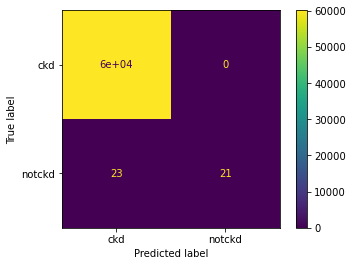

In [60]:
confusion_mat = confusion_matrix(y_test_bst, logreg.predict(Z_test_bst), labels=['ckd','notckd'])
ConfusionMatrixDisplay(confusion_mat, display_labels=['ckd','notckd']).plot();

In [100]:
from sklearn.metrics import precision_score, f1_score, recall_score

In [102]:
y_pred = logreg.predict(Z_test_bst)
y_actual = y_test_bst.to_numpy()

# F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print(f"F1 score: {f1_score(y_actual, y_pred, pos_label='ckd')}")

# specificity score is recall score of the 'notckd' label
# (tn / (tn+fp))
print(f"Specificity score: {recall_score(y_actual, y_pred, pos_label='notckd')}")

# recall/sensitivity/true positive rate score
# (tp / (tp+fn))
print(f"Recall score: {recall_score(y_actual, y_pred, pos_label='ckd')}")

# precision score
# (tp / (fp+tp))
print(f"Precision score: {precision_score(y_actual, y_pred, pos_label='ckd')}")

F1 score: 0.9998086124401914
Specificity score: 0.4772727272727273
Recall score: 1.0
Precision score: 0.9996172981247609


The impact of unbalanced class data fitted into a logistic regression model results in a model that has high sensitivity for majority class, but low specificity. Many patients that **do not** truly have CKD, will be wrongly diagnosed by the model as having CKD. 

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

Set baseline as majority count. Coz can affect classification regression performance